In [1]:
!pip install cesium

In [2]:
!pip install sncosmo
#!conda install -c astropy sncosmo

In [3]:
!pip install schwimmbad

In [7]:
import os
import numpy as np
import scipy.stats as spstat
import matplotlib.pyplot as plt
from collections import OrderedDict
import sncosmo
from astropy.table import Table
import pywt
import pywt.data
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plot
import sys
import os
from collections import Counter, OrderedDict
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from astropy.table import Table
import schwimmbad
from cesium.time_series import TimeSeries
import cesium.featurize as featurize
from tqdm import tnrange, tqdm_notebook
import sklearn 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [6]:
!pip install seaborn

In [8]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [5]:
#In case you use Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
#Ler uma tabela astropy
filename='training_set.csv'
training_data = Table.read(filename, format='ascii.csv')

NameError: name 'Table' is not defined

In [8]:
print(training_data.info)
print(training_data)

<Table length=1421705>
   name    dtype 
--------- -------
object_id   int64
      mjd float64
 passband   int64
     flux float64
 flux_err float64
 detected   int64

object_id    mjd     passband     flux      flux_err detected
--------- ---------- -------- ------------ --------- --------
      615 59750.4229        2  -544.810303  3.622952        1
      615 59750.4306        1  -816.434326   5.55337        1
      615 59750.4383        3  -471.385529  3.801213        1
      615  59750.445        4  -388.984985 11.395031        1
      615  59752.407        2  -681.858887  4.041204        1
      615 59752.4147        1 -1061.457031  6.472994        1
      615 59752.4224        3   -524.95459  3.552751        1
      615 59752.4334        4  -393.480225  3.599346        1
      615 59752.4435        5   -355.88678 10.421921        1
      615 59767.2968        2   -548.01355  3.462291        1
      ...        ...      ...          ...       ...      ...
130779836  60537.147      

In [0]:
#Ler uma tabela astropy
filename='/content/drive/My Drive/MLprojeto/training_set_metadata.csv'
meta_training = Table.read(filename, format='ascii.csv')
nobjects = len(meta_training)

In [10]:
print(meta_training.info)

<Table length=7848>
       name         dtype  n_bad
------------------ ------- -----
         object_id   int64     0
                ra float64     0
              decl float64     0
             gal_l float64     0
             gal_b float64     0
               ddf   int64     0
     hostgal_specz float64     0
    hostgal_photoz float64     0
hostgal_photoz_err float64     0
           distmod float64  2325
             mwebv float64     0
            target   int64     0



In [11]:
print(meta_training)

object_id     ra        decl      gal_l    ... distmod mwebv target
--------- ---------- ---------- ---------- ... ------- ----- ------
      615 349.046051 -61.943836  320.79653 ...     nan 0.017     92
      713  53.085938 -27.784405 223.525509 ... 45.4063 0.007     88
      730  33.574219  -6.579593 170.455585 ... 40.2561 0.021     42
      745   0.189873 -45.586655 328.254458 ... 40.7951 0.007     90
     1124 352.711273 -63.823658 316.922299 ... 40.4166 0.024     90
     1227  35.683594  -5.379379 171.992947 ...     nan  0.02     65
     1598  347.84671 -64.760857 318.929827 ... 39.7279 0.019     90
     1632 348.595886  -63.07262 320.023289 ... 43.1524 0.021     42
     1920 149.414062   3.433834 234.919132 ... 41.1401 0.027     90
     1926 149.414062   1.940072 236.565366 ...     nan 0.018     65
      ...        ...        ...        ... ...     ...   ...    ...
130678775 142.734375 -23.480536 254.430952 ... 38.0319 0.056     64
130684460 117.949219  -0.895283 220.752608 ...  

In [0]:
target_vec=np.asarray(meta_training['target'])

In [13]:
unique_targets = np.unique(target_vec)
print ("There are {} unique targets.".format(len(unique_targets)))
print (unique_targets)

There are 14 unique targets.
[ 6 15 16 42 52 53 62 64 65 67 88 90 92 95]


Number of objects of each class
[   0.  495.  924. 1193.  183.   30.  484.  102.  981.  208.  370. 2313.
  239.  175.]


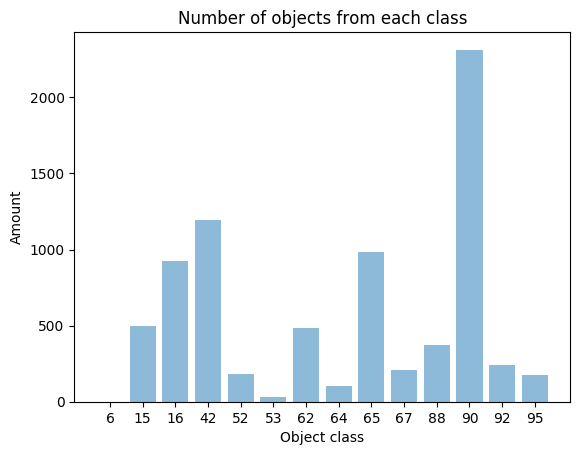

In [14]:
hist_count=np.zeros([len(unique_targets),1])
for i in range (1,len(unique_targets)):
    hist_count[i,0]=np.count_nonzero(target_vec[target_vec==unique_targets[i]])


print('Number of objects of each class')
print(hist_count.ravel())
 
import matplotlib.pyplot as plt; plt.rcdefaults()
objects = ('6', '15', '16', '42', '52', '53', '62','64','65','67','88','90','92','95')
y_pos = np.arange(len(objects))
performance = hist_count.ravel()

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Amount')
plt.xlabel('Object class')
plt.title('Number of objects from each class') 
plt.show()

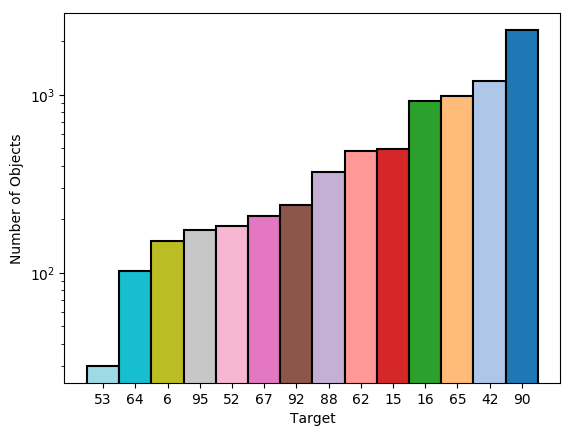

In [15]:
counts = Counter(meta_training['target'])
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))


cmap = plt.cm.tab20
nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

# we'll create a mapping between class and color
classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
plt.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
plt.xlabel('Target')
plt.ylabel('Number of Objects')
plt.show()

Dict das bandas passantes

In [0]:
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())

Criar as timeseries com o cesium

In [17]:
import ipywidgets

tsdict = OrderedDict() #time series dict

for i in tnrange(nobjects, desc='Building Timeseries'):
    row = meta_training[i]
    thisid = row['object_id']
    target = row['target']
    
    meta = {'z':row['hostgal_photoz'],\
            'zerr':row['hostgal_photoz_err'],\
            'mwebv':row['mwebv']}
    
    ind = (training_data['object_id'] == thisid)
    thislc = training_data[ind]

    pbind = [(thislc['passband'] == pb) for pb in pbmap]
    t = [thislc['mjd'][mask].data for mask in pbind ]
    m = [thislc['flux'][mask].data for mask in pbind ]
    e = [thislc['flux_err'][mask].data for mask in pbind ]

    tsdict[thisid] = TimeSeries(t=t, m=m, e=e,\
                        label=target, name=thisid, meta_features=meta,\
                        channel_names=pbnames )
    
del training_data

In [0]:
#print('Famílias de wavelets disponíveis')
#print(pywt.wavelist())

In [0]:
'''
À trous wavelet transform é esta!!!!!! https://pywavelets.readthedocs.io/en/latest/ref/swt-stationary-wavelet-transform.html
'''
# Criar o objeto wavelet
w = pywt.Wavelet('sym2')
#calculo que a família de wavelets que escolhi seja a symlet, pelo nome, e que é uma two level wavelet transform, mas confirmar

In [20]:
print(w)

Wavelet sym2
  Family name:    Symlets
  Short name:     sym
  Filters length: 4
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       near symmetric
  DWT:            True
  CWT:            False


In [21]:
space_times = []
space_measurements = []
space_errors = []
for index in tsdict:
  n_channels = tsdict[index].n_channels
  space_times.append([t for t in tsdict[index].time])
  #space_measurements.append([pywt.wavedec(m, pywt.Wavelet("sym2"), level=n_channels) for m in tsdict[index].measurement])
  space_measurements.append([m for m in tsdict[index].measurenment])
  space_errors.append([e for e in tsdict[index].error])

#print(space_times)
#print("\n")
#print(space_measurements)
#print("\n")
#print(space_errors)

#Sample code
#n_channels = tsdict[615].n_channels
#space["times"] = [t for t in tsdict[615].time]
#space["dwts"] = [pywt.wavedec(m, pywt.Wavelet("sym2"), level=n_channels) for m in tsdict[615].measurement]
#space["errors"] = [e for e in tsdict[615].error]
#fset_dwt = featurize.featurize_time_series(times=None, values=space["dwts"], errors=None, meta_features=tsdict[615].meta_features)
#fset_nowave = featurize.featurize_time_series(times=space["times"])
#print(fset_dwt.head())
#space["times"]
#for m in tsdict[615].measurement:
  #print((m))

/usr/local/lib/python2.7/dist-packages/pywt/_multilevel.py:45: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


In [22]:
space_meta_features = []
for index in tsdict:
  space_meta_features.append(tsdict[index].meta_features)
print(len(space_meta_features))

7848


In [24]:
import pickle
with open("space_times.p", 'rb') as t:
    space_times = pickle.load(t)


#m = open("space_measurements.p", 'rb')
#space_measurements = pickle.load("space_measurements.p")
#m.close()

#e = open("space_errors.p", 'rb')
#space_errors = pickle.load("space_errors.p")
#e.close()

#mf = open("space_meta_features.p", 'rb')
#space_meta_features = pickle.load("space_meta_features.p")
#mf.close()

EOFError: Ran out of input

In [25]:
features = []
for index in range(len(space_meta_features)):
    print(index)
    fset = featurize.featurize_time_series(times=space_times[index], values=space_measurements[index], errors=space_errors[index], 
                                         meta_features=space_meta_features[index])
    features.append(fset)
    
print(len(features))

NameError: name 'space_meta_features' is not defined

Para a Gaussian Process Regression

In [0]:
# Interpolação das light curves usando gaussian process regression 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

gpdict = OrderedDict() #time series after gaussian process dict
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel,random_state=0).fit(x,y) #FALTA MUDAR O X E O Y

Para a PCA

In [0]:
pca = PCA(n_components=npca, whiten=True, svd_solver="full", random_state=42)
Xtrain_pca = pca.fit_transform(Xtrain)